In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

2022-06-06 14:30:34.725360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/gonzalez/TOOLS/elmer/install//lib
2022-06-06 14:30:34.725415: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
# from google.colab import drive 
# drive.mount('/content/gdrive')
# data=pd.read_csv('gdrive/My Drive/age_gender.csv')

In [2]:
data_path = '/home/gonzalez/Desktop/age_gender/age_gender.csv' # old data
data = pd.read_csv(data_path)

In [ ]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

for j in range(len(data)):
    data['pixels'][j]=data['pixels'][j]/255

In [ ]:
# list the number of counts per age
ages = data['age'].unique()
counts = []
for age in ages:
    counts.append(np.count_nonzero(data['age']==age))

In [ ]:
# table with the first 15 most dense samples regarding age
# type(ages), type(counts)
# s =pd.DataFrame([ages.T, np.array(counts).T],['ages', 'counts'])
# s=s.transpose()
# more_dense = s.sort_values(by=['counts'], ascending=False)
# more_dense.head(15)

In [3]:
#data = data.drop(data[data.age==26].index).copy()
data = data.drop(data[data.age<5].index).copy()
data = data.drop(data[data.age>80].index).copy()

data.reset_index(drop=True)

,age,ethnicity,gender,img_name,pixels
0,10,0,0,20170110225414790.jpg.chip.jpg,30 38 50 90 109 113 126 130 136 139 147 149 15...
1,10,0,0,20170110225417177.jpg.chip.jpg,72 81 94 96 77 85 90 71 76 90 87 80 91 103 118...
2,10,0,0,20170110224549512.jpg.chip.jpg,255 253 252 221 144 174 165 151 151 186 185 14...
3,10,0,0,20170110225402690.jpg.chip.jpg,62 53 55 62 73 74 86 94 106 121 139 161 170 15...
4,10,0,0,20170110225421531.jpg.chip.jpg,28 60 55 55 74 74 62 101 147 140 166 147 161 1...
...,...,...,...,...,...
20993,9,0,0,20170110215653284.jpg.chip.jpg,73 66 78 108 112 124 128 133 142 152 161 169 1...
20994,9,0,0,20170110215848132.jpg.chip.jpg,74 89 51 63 69 80 94 95 92 105 121 136 147 156...
20995,9,0,0,20170110220005370.jpg.chip.jpg,98 90 90 111 133 149 169 171 169 168 163 154 1...
20996,9,0,0,20170110220016235.jpg.chip.jpg,57 74 93 92 110 124 130 133 153 161 159 152 14...


In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale = 1.5)
p = sns.histplot(data['age'], color='blue')
p.set_title("Age distribution")
p.set_ylabel("Count",fontsize=20)
p.set_xlabel("Age",fontsize=20)
plt.savefig('filtered_age_distribution.png')

In [ ]:
# from PIL import Image, ImageOps
# import numpy as np

# def pixel_mirroring(pixel):
#     '''Mirroring a pixel from the prepared dataset'''

#     #Turn the pixel list into an array 48,48
#     array=np.uint8(pixel.reshape((48,48)))

#     #Turn the array into an image object and mirror it
#     img=Image.fromarray(array, 'L')
#     img=ImageOps.mirror(img)

#     #Turn the image back into a pixel list
#     img=img.getdata()
#     pixel_mirror=np.array(img, dtype=np.float32)

#     return pixel_mirror

In [ ]:
# def count_amout_per_age(data):
#     ages = data['age'].unique()
#     counts = []
#     for age in ages:
#         counts.append(np.count_nonzero(data['age']==age))

#     type(ages), type(counts)
#     s =pd.DataFrame([ages.T, np.array(counts).T],['ages', 'counts'])
#     s=s.transpose()
#     more_dense = s.sort_values(by=['counts'], ascending=True)
#     more_dense.head(15)
#     return more_dense

In [5]:
# categorize age per range:
def age_categorize(input_list, age_step=10):
    '''
    Enter the list of age into input_list and the age steps
    with : age_step = 5;  age = 4   =>  1-5
                          age = 12  =>  10-15                        
    '''
    
    cat_age = []
    for age in input_list:
        
        a = float(age)/float(age_step)
        
        if a > 1:
            entero = int(a)
            coma = a-entero
            
            if coma > 0:
                entero = entero+1
            
            max = entero * age_step
            min = max-(age_step-1)     
            #cat_age.append(f'{min} to {max}')   # if the output is in the real intervale
            cat_age.append(int(max/age_step)-1)  # if the output is in categorical int number
        else:
            min = 1
            max = age_step
            #cat_age.append(f'{min} to {max}')    # if the output is in the real intervale   
            cat_age.append(int(max/age_step)-1)   # if the output is in categorical int number           
    return cat_age




def age_categorize_custom(input_list, custom = [0, 15, 35, 60, 150]):
    category = list(range(0,len(custom)))
    data['age'].unique()
    cat_age = []

    for edad in data['age']:
        category = list(range(0,len(custom)))
        for cate in category:
            if edad<custom[cate]:
                #print(edad, cate, custom[cate-1], custom[cate])
                cat_age.append(cate)
                break
    return cat_age

In [ ]:
# dense = count_amout_per_age(data)

# more = dense[dense.counts>600].copy()['ages'].unique()
# less = dense[dense.counts<600].copy()['ages'].unique()

# data_less = data.copy()
# data_more = data.copy()

# for age in more:
#     data_less = data_less.drop(data_less[data_less.age==age].index).copy()

# for age in less:
#     data_more = data_more.drop(data_more[data_more.age==age].index).copy()

In [ ]:
# mirrored = []
# for images in data_less['pixels']:
#     mirrored.append(pixel_mirroring(images))

# data_less_mirrored = data_less.copy()
# data_less_mirrored['mirrored']=mirrored

# data_less_mirrored.drop(columns=['pixels'], inplace=True)
# data_less_mirrored.rename(columns={'mirrored':'pixels'}, inplace=True)


# # merge two data frames, reste indexes
# presque = pd.concat([data_less, data_less_mirrored, data_more]).reset_index(drop=True, inplace=False) 

# #presque.drop_duplicates(inplace=True)

In [ ]:
# sns.histplot(data.age);
# sns.histplot(presque['age']);

In [ ]:
# data = presque.copy()

/tmp/ipykernel_6761/1749851224.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(['0.0','5-20','','','','21-50','','','','50-80'])


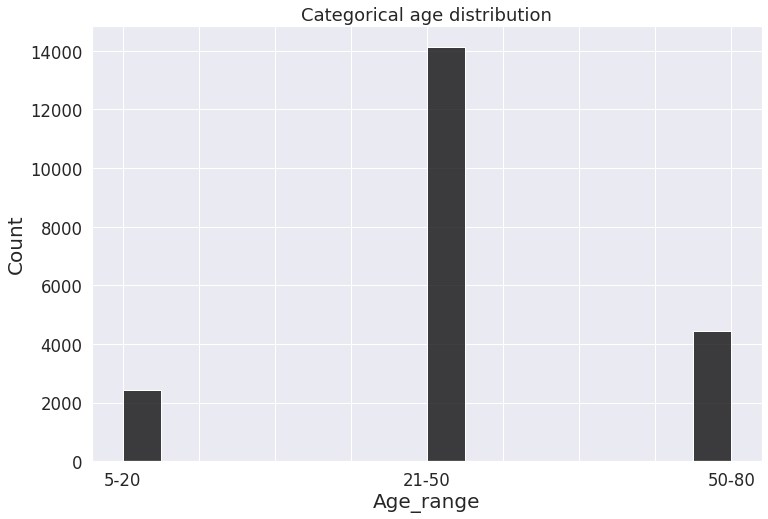

In [20]:
# step_size = 5
# input_list = data['age']
# cat = age_categorize(input_list, step_size)  # ====>>  INITIALIZE THIS FUNCTION  <<=========


input_list = data['age']
custom = [5, 20, 50, 85]
cat = age_categorize_custom(input_list, custom)  # ====>>  INITIALIZE THIS FUNCTION  <<=========


#pd.DataFrame(cat, data['age'].values).sample(100)


# add categorical age clasification to original dataframe
data['points_bin']=cat
#data[['age','class_age']].sample(10)

fig, ax = plt.subplots(figsize=(12,8))
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)

p = sns.histplot(data=data, x='points_bin', color='black');
p.set_title("Categorical age distribution")

p.set_ylabel("Count",fontsize=20)
p.set_xlabel("Age_range",fontsize=20)
p.set_xticklabels(['0.0','5-20','','','','21-50','','','','50-80'])
plt.savefig('categorical_age_distribution.png')

In [ ]:
### perform one-hot encoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
ohe.fit(data[['points_bin']])
class_age_encoded = ohe.transform(data[['points_bin']])


for elements in range(class_age_encoded.shape[1]):      # =====> THIS IS NEED WHATHERVER HOT ENCODER USED  <=====
    data[str(elements)]=class_age_encoded[:,elements]

In [ ]:
data.sample(10)

Preparing FIT

In [ ]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y=data.drop(columns=['age','ethnicity','gender', 'pixels', 'points_bin', 'img_name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [ ]:
def initialize_model_catgorical(numb_int, numb_out):
        
    model = Sequential()
    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu',input_shape=(48,48,numb_int)))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(320,(3,3), padding='same',activation='relu'))
    model.add(layers.Conv2D(320,(3,3), padding='same',activation='relu'))

    model.add(layers.Conv2D(320,(3,3), padding='same',activation='relu'))


    model.add(layers.Conv2D(520,(3,3), padding='same',activation='relu'))

    model.add(layers.Conv2D(520,(3,3), padding='same',activation='relu'))

    model.add(layers.Conv2D(520,(3,3), padding='same',activation='relu'))
    model.add(layers.Conv2D(520,(3,3), padding='same',activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
   
    model.add(layers.Dense(numb_out, activation='softmax'))   
    return model

In [ ]:
model_cat = initialize_model_catgorical(X.shape[-1], y.shape[-1])
    
es = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

model_cat.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

history_cat = model_cat.fit(X_train,y_train, validation_split=0.3, epochs=50, callbacks=[es])

In [ ]:
plt.plot(history_cat.history['accuracy'])
plt.plot(history_cat.history['val_accuracy'])

In [ ]:
models.save_model(model_cat,'Model_cat_custom_Pierre')

In [ ]:
model_cat.evaluate(X_test, y_test)

# RUN LINEAR REGRESSION FOR EACH PART

In [ ]:
lower = data['points_bin'].unique()[1]
upper = data['points_bin'].unique()[2]

cacho = data.drop(data[data.points_bin<lower].index | data[data.points_bin>=upper].index).copy()
cacho['age'].unique()

In [ ]:
def initialize_model_regression():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

In [ ]:
print(np.sort(list(data['points_bin'].unique())))
print(data['points_bin'].unique())

In [ ]:
# looping for all linear model
Histories = []

y = data['age']

for i in range(len(np.sort(list(data['points_bin'].unique())))):


    # slice the dataframe
    
    #lower = data['points_bin'].unique()[i].left  # ====>>  USING PIERRE FORMAT  <<=========
    #upper = data['points_bin'].unique()[i].right
    #cacho = data.drop(data[data.age<lower].index | data[data.age>=upper].index).copy()
    
    #lower = data['points_bin'].unique()[i]   # ====>>  USING JAVIER FORMAT  <<=========
    #upper = data['points_bin'].unique()[i+1]

    lower = np.sort(list(data['points_bin'].unique()))[i]   # ====>>  USING JAVIER FORMAT  <<=========
    upper = np.sort(list(data['points_bin'].unique()))[i]+1

    cacho = data.drop(data[data.points_bin<lower].index | data[data.points_bin>=upper].index).copy()
    print(lower, upper)
    
    # prepare the data
    X = cacho['pixels'].tolist()
    X = np.reshape(X, (-1, 48, 48,1))

    y=cacho['age']

    # split data set
    X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=1)
    
    
    print(' ')
    print('*****************************************************************************************')
    print(f'STARTING MODEL =======>>>>>> {i} with age range {y.min()} to {y.max()} and {X.shape} samples')
    print('*****************************************************************************************')
    print(' ')


    # initialize the model
    model = initialize_model_regression()
        
    # compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    
    # early stopping
    es = EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)


    # fit
    history = model.fit(X_train, y_train, validation_split=0.3, epochs=40, callbacks=[es])
    
    # save model
    Histories.append(history)
    
    models.save_model(model, f'Model_linear_{y.min()}_{y.max()}')
    
    # delete variables to save RAM
    del model, X, y, X_train, X_test, y_train, y_test, es, history, cacho

In [ ]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48))


In [ ]:
n=279
plt.imshow(X[n], cmap='gray');
#np.where(y.iloc[n]==1)[0]
print(f"real age is {data.iloc[n]}")

In [ ]:
# try_inp = np.expand_dims(X[n], axis=0)
# model_cat.predict(try_inp).max()
# index = np.where(model_cat.predict(try_inp)==(model_cat.predict(try_inp).max()))
# print(f'slot number {index[1][0]}, correspond to range {(index[1][0]+1)*step_size-step_size} to {(index[1][0]+1)*step_size}')

In [ ]:
try_inp = np.expand_dims(X[n], axis=0)
model_cat.predict(try_inp).max()
index = np.where(model_cat.predict(try_inp)==(model_cat.predict(try_inp).max()))
print(f'slot number {index[1][0]}, correspond to range {custom[index[1][0]-1]} to {custom[index[1][0]]}')

In [ ]:
! ls

In [ ]:
# load corresponding regresional model
predict_model = models.load_model('Model_linear_1_10')

In [ ]:
# predict regresional
predict_model.predict(try_inp)